In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [161]:
def exponential_mechanism_slice(X: list, q: float, eps: float, bound: tuple[float, float],
                                slice: tuple[int, int] = None
                                ) -> float:
    n = len(X)
    rank = np.floor(q * n)
    # get slice
    if slice is None:
        # get all elements
        slice = (1, n)
    X = [X[i - 1] for i in range(slice[0], slice[1] + 1)]

    # add left bound and right bound to X
    X = [bound[0]] + X + [bound[1]]

    # get an iterator
    iterator = zip(X[:-1], X[1:])
    # get utility

    utility = np.array([-abs(i - 1 - rank) for i in range(slice[0], slice[1] + 2)])

    # utility = np.array([-abs(i - 1 - rank) for i in range(slice[0], slice[1] + 1)])
    # utility = np.append(utility, -abs(n - rank))
    #
    # utility = [-rank]
    # utility = utility + [-abs(i - 1 - rank) for i in range(slice[0] + 1, slice[1] + 1)]
    # utility = utility + [-abs(n - rank)]

    # check one utility is 0
    assert utility[utility == 0].size == 1, "There should be only one utility that is 0"

    # compute the scores
    scores = np.array([np.exp((eps / 2) * u) * (I[1] - I[0]) for I, u in zip(iterator, utility)])
    # of there is a negative score, print it
    if np.any(scores < 0):
        print("Negative score")
        print(utility)
        print(scores)
    idx = np.random.choice(len(scores), p=scores / np.sum(scores))
    sample = np.random.uniform(X[idx], X[idx + 1])
    return sample

In [162]:
def error(X: list, q: float, estimate: float) -> float:
    n = len(X)
    # for each result, get the position of the closest element in the sorted array
    position = np.searchsorted(X, estimate)
    true_positions = math.floor(q * n)
    # compute the rank error
    rank_error = np.abs(position - true_positions)
    return rank_error

In [163]:
def upper_bound(eps: float, beta: float, B: float, g: float) -> float:
    return 2 * np.log(B / (g * beta)) / eps

In [164]:
def generate_uniform_sample(n: int, bounds: tuple[int, int], seed: float = None, epsilon=1e-10) -> list[float]:
    if seed is not None:
        np.random.seed(seed)
    # generate n samples from a uniform distribution
    return np.random.uniform(bounds[0] + epsilon, bounds[1], n).tolist()

In [169]:
n = 10_000
eps = 0.1
slice_parameter = range(1, 300)
bounds = (0, 2 ** 32)
X = generate_uniform_sample(n, bounds, seed=42)
X = np.sort(X)
q = 0.05
q_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
g = min(abs(X[i] - X[i - 1]) for i in range(1, n))
B = bounds[1] - bounds[0]
experiments = 100
results = np.zeros((len(slice_parameter), experiments))
for i, l in enumerate(slice_parameter):
    if l == "no slice":
        slice = (1, n)
    else:
        slice = (math.floor(q * n) - l, math.floor(q * n) + l + 1)
    for j in range(experiments):
        estimate = exponential_mechanism_slice(X, q, eps, bounds, slice)
        results[i][j] = error(X, q, estimate)

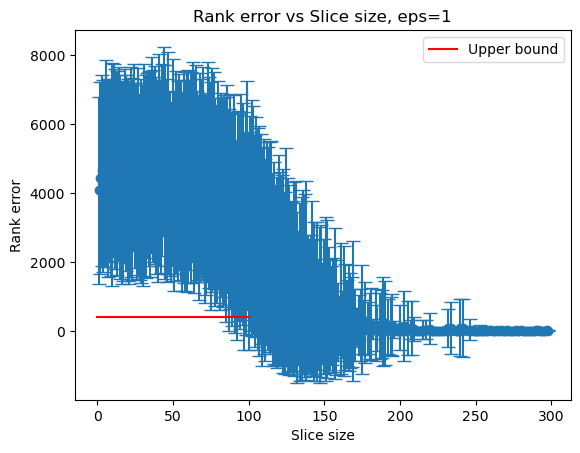

In [170]:
# plot the results
fig, ax = plt.subplots()
x = slice_parameter[:-1]
y = results[:-1].mean(axis=1)
yerr = results[:-1].std(axis=1)
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5)
ax.set_xlabel('Slice size')
# log scale on x
ax.set_ylabel('Rank error')
ax.set_title('Rank error vs Slice size, eps=1')

# add line for the upper bound
up = upper_bound(eps, 0.05, B, g)
x = np.linspace(0, 100, 100)
y = np.ones_like(x) * up
ax.plot(x, y, label='Upper bound', color='red')
ax.legend()
plt.show()

In [107]:
n = 10_000
eps = 1
slice_parameter = range(1, 100)
bounds = (0, 2 ** 32)
X = generate_uniform_sample(n, bounds, seed=42)
X = np.sort(X)
q_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
g = min(abs(X[i] - X[i - 1]) for i in range(1, n))
B = bounds[1] - bounds[0]
experiments = 50
results = np.zeros((len(q_list), len(slice_parameter), experiments))
for k, q in enumerate(q_list):
    for i, l in enumerate(slice_parameter):
        if l == "no slice":
            slice = (1, n)
        else:
            slice = (math.floor(q * n) - l, math.floor(q * n) + l + 1)
        for j in range(experiments):
            estimate = exponential_mechanism_slice(X, q, eps, bounds, slice)
            results[k][i][j] = error(X, q, estimate)

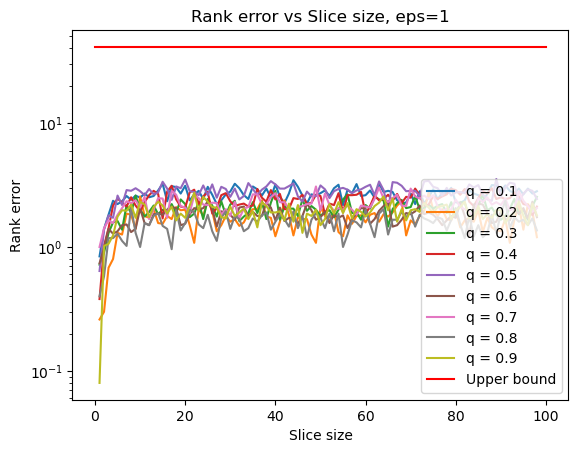

In [108]:
# plot the results
fig, ax = plt.subplots()
x = slice_parameter[:-1]
for i, q in enumerate(q_list):
    y = results[i][:][:-1].mean(axis=1)
    ax.plot(x, y, label='q = %s' % q)
ax.set_xlabel('Slice size')
# log scale on x
ax.set_ylabel('Rank error')
ax.set_title('Rank error vs Slice size, eps=1')

# add line for the upper bound
up = upper_bound(eps, 0.05, B, g)
x = np.linspace(0, 100, 100)
y = np.ones_like(x) * up
ax.plot(x, y, label='Upper bound', color='red')
ax.legend()
# set log y axis
ax.set_yscale('log')
plt.show()

In [15]:

yerr

array([1.36746845e+03, 1.38994164e+03, 1.40091937e+03, 1.40839689e+03,
       1.37828598e+03, 1.45076385e+03, 1.46969102e+03, 1.34608042e+03,
       1.49804966e+03, 1.76381865e+03, 1.49888553e+03, 1.65209887e+03,
       1.70146239e+03, 1.70821496e+03, 1.74362988e+03, 1.71610841e+03,
       1.30707002e+03, 1.19077599e+03, 9.67973159e+02, 7.52696150e+02,
       5.54476731e+02, 4.57279606e+02, 2.91819890e+02, 1.81358760e+00,
       2.54705713e+00, 2.00686322e+00, 1.95510289e+02, 1.90291881e+00,
       5.99764712e+01, 1.87539329e+00, 2.49767892e+00, 2.43515913e+00,
       2.70155511e+00, 2.06152856e+00, 1.93649167e+00, 2.63763151e+00,
       2.26492825e+00, 1.90207781e+00, 1.93584607e+00, 2.00686322e+00,
       1.74653944e+00, 1.89166593e+00, 2.13906522e+00, 2.18346056e+00,
       2.71396389e+00, 1.94432508e+00, 2.43874968e+00, 2.43874968e+00,
       2.40039580e+00, 2.07699302e+00, 1.68226038e+00, 1.89736660e+00,
       2.05436121e+00, 1.90777357e+00, 2.34145254e+00, 2.36429694e+00,
      

In [322]:
n = 10_000
eps = 0.1
slice_parameter = range(1, 1000)
bounds = (0, 2 ** 32)
X = generate_uniform_sample(n, bounds, seed=42)
X = np.sort(X)
q = 0.5
experiments = 100
results = np.zeros((len(slice_parameter), experiments))
for i, l in enumerate(slice_parameter):
    if l == "no slice":
        slice = (1, n)
    else:
        slice = (math.floor(q * n) - l, math.floor(q * n) + l + 1)
    for j in range(experiments):
        estimate = exponential_mechanism_slice(X, q, eps, bounds, slice)
        results[i][j] = error(X, q, estimate)

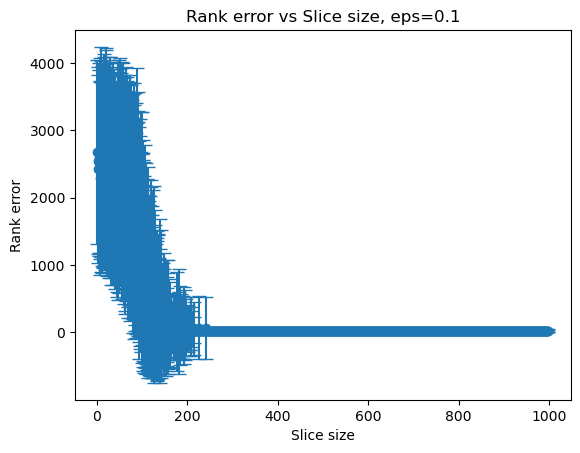

In [323]:
# plot the results
fig, ax = plt.subplots()
x = slice_parameter[:-1]
y = results[:-1].mean(axis=1)
yerr = results[:-1].std(axis=1)
ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5)
ax.set_xlabel('Slice size')
# log scale on x
ax.set_ylabel('Rank error')
ax.set_title('Rank error vs Slice size, eps=0.1')
plt.show()